# 1. Buoyancy Frequency Profile

To be in accordance with TEOS-10 it translates from Salinity_[psu] & Temp_[°C] into Absolute_Salinity [g/kg] & Conservative_Temp_deg [°C]. As sources I used the TEOS-10 book, some ChatGPT, lots of StackOverflow or Python Library Documentations (which I can easily quote), and also Work/Study coding experience for which giving sources like "my own memory" isnt feasible.

Precise explanations to be found in the code

## Density Calculation

In [34]:
from pathlib import Path
import numpy as np
import pandas as pd
import gsw

# Paths
UDASH_FILE = Path("UDASH/ArcticOcean_phys_oce_2010.txt")
OUTPUT_DIR = Path("Density")
MISSING_VALUE = -999.0

# Finding the year within the txt
def _infer_year_from_timestamp(series: pd.Series) -> str:
    """Try to infer a year from the yyyy-mm-ddThh:mm column."""
    s = series.dropna().astype(str)
    if s.empty:
        return "unknown"
    first = s.iloc[0]
    try:
        return str(pd.to_datetime(first).year)
    except Exception:
        return str(first)[:4]

# Read raw UDASH file
def process_udash_file(path: Path, output_dir: Path = OUTPUT_DIR) -> tuple[pd.DataFrame, Path]:
    df = pd.read_csv(
        path,
        delim_whitespace=True,
        na_values=[MISSING_VALUE],
        engine="python",
    )

    # Replace explicit missing flag just in case
    df = df.replace(MISSING_VALUE, np.nan)

    # Make sure key columns exist
    required_cols = [
        "Prof_no",
        "Cruise",
        "Station",
        "Platform",
        "Type",
        "yyyy-mm-ddThh:mm",
        "Longitude_[deg]",
        "Latitude_[deg]",
        "Pressure_[dbar]",
        "Depth_[m]",
        "Temp_[°C]",
        "Salinity_[psu]",
    ]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in UDASH file: {missing}")

    # Sort so casts stay together and levels are ordered
    sort_keys = [
        "Prof_no",
        "yyyy-mm-ddThh:mm",
        "Depth_[m]",
        "Pressure_[dbar]",
    ]
    sort_keys = [k for k in sort_keys if k in df.columns]
    df = df.sort_values(sort_keys).reset_index(drop=True)

    # TEOS-10 inputs
    SP = df["Salinity_[psu]"].to_numpy(float)
    t = df["Temp_[°C]"].to_numpy(float)
    p = df["Pressure_[dbar]"].to_numpy(float)
    lon = df["Longitude_[deg]"].to_numpy(float)
    lat = df["Latitude_[deg]"].to_numpy(float)

    # ChatGPT: Range-based masking
    def _mask_range(arr, lo, hi):
        bad = (arr < lo) | (arr > hi)
        arr = arr.copy()
        arr[bad] = np.nan
        return arr
    
    # ChatGPT: Range-based masking
    lat = _mask_range(lat, -90, 90)
    lon = _mask_range(lon, -180, 360)
    p = _mask_range(p, 0, 12000)
    SP = _mask_range(SP, 0, 50)
    t = _mask_range(t, -5, 40)

    # TEOS-10 computations
    SA = gsw.SA_from_SP(SP, p, lon, lat)           # Absolute salinity [g/kg]
    CT = gsw.CT_from_t(SA, t, p)                   # Conservative temperature [°C]
    rho = gsw.rho(SA, CT, p)                       # In-situ density [kg/m³]
    sigma0 = gsw.sigma0(SA, CT) + 1000.0           # Potential density σ0 + 1000

    # Attach TEOS-10 variables + source_file
    df = df.copy()
    df.insert(0, "source_file", path.name)
    df["Absolute_Salinity_g_kg"] = SA
    df["Conservative_Temp_degC"] = CT
    df["Density_kg_m3"] = rho
    df["Potential_Density_kg_m3"] = sigma0

    # Build output path with year tag
    year = _infer_year_from_timestamp(df["yyyy-mm-ddThh:mm"])
    output_dir.mkdir(parents=True, exist_ok=True)
    out_path = output_dir / f"{year}_{path.stem}_teos10.txt"

    # Choose column order for TEOS-10 file (I prefer to save more rather than less)
    out_cols = [
        "source_file",
        "Prof_no",
        "yyyy-mm-ddThh:mm",
        "Longitude_[deg]",
        "Latitude_[deg]",
        "Pressure_[dbar]",
        "Depth_[m]",
        "Temp_[°C]",
        "Salinity_[psu]",
        "Absolute_Salinity_g_kg",
        "Conservative_Temp_degC",
        "Density_kg_m3",
        "Potential_Density_kg_m3",
    ]
    out_cols = [c for c in out_cols if c in df.columns]

    # Write nicely sorted TEOS-10 file
    df[out_cols].to_csv(
        out_path,
        sep="\t",
        index=False,
        float_format="%.6f",
    )

    print(f"Loaded {len(df)} rows from {path}")
    print(f"TEOS-10 file written to: {out_path}")
    return df, out_path


# EXECUTION
df_teos10, teos10_path = process_udash_file(UDASH_FILE)

# Show a quick preview
df_teos10.head()

/tmp/ipykernel_28586/2968834839.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Loaded 4222752 rows from UDASH/ArcticOcean_phys_oce_2010.txt
TEOS-10 file written to: Density/2010_ArcticOcean_phys_oce_2010_teos10.txt


,source_file,Prof_no,Cruise,Station,Platform,Type,yyyy-mm-ddThh:mm,Longitude_[deg],Latitude_[deg],Pressure_[dbar],...,Salinity_[psu],QF.2,Source,DOI,WOD-Cruise-ID,WOD-Cast-ID,Absolute_Salinity_g_kg,Conservative_Temp_degC,Density_kg_m3,Potential_Density_kg_m3
0,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,5.0,...,35.2074,0,ices,NaN,NaN,NaN,35.374720,7.293950,1027.563862,1027.541038
1,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,6.0,...,35.2075,0,ices,NaN,NaN,NaN,35.374825,7.293853,1027.568522,1027.541134
2,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,7.0,...,35.2077,0,ices,NaN,NaN,NaN,35.375031,7.293755,1027.573261,1027.541308
3,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,8.0,...,35.2076,0,ices,NaN,NaN,NaN,35.374935,7.294660,1027.577620,1027.541104
4,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,9.0,...,35.2079,0,ices,NaN,NaN,NaN,35.375241,7.293562,1027.582581,1027.541500


## Buoyancy Calculation

From the just calculated density I here now calculate the buoyancy profile for all the casts in a given year.


In [36]:
from pathlib import Path
import numpy as np
import pandas as pd
import gsw

# Define tunable QC thresholds for the quality control parameter that will be introduced later
MIN_DEPTH_RANGE_OK = 200.0   # [m] minimum depth range to be "acceptable"
MIN_DEPTH_RANGE_GOOD = 400.0 # [m] minimum depth range to be "good"
MAX_GAP_GOOD = 50.0          # [m] maximum vertical gap to still call it "good"

# Path
UDASH_FILE = Path("UDASH/ArcticOcean_phys_oce_2010.txt")
TEOS_DIR = Path("Density")
N2_DIR = Path("N2")

# CHATGPT: Find the TEOS-10 file produced earlier (For some reason I can never grasp how to retrieve paths...)
pattern = f"*_{UDASH_FILE.stem}_teos10.txt"
teos_files = sorted(TEOS_DIR.glob(pattern))
if not teos_files:
    raise FileNotFoundError(f"No TEOS-10 file matching {pattern} in {TEOS_DIR}")
TEOS10_FILE = teos_files[0]

# Load TEOS-10 data
df = pd.read_csv(TEOS10_FILE, sep="\t")

def compute_N2_for_cast(g: pd.DataFrame) -> pd.DataFrame | None:
    """
    Compute N2 for a single cast, keeping metadata and QC (quality control parameters).

    QC includes:
      - Chelton style overwriting of negative N2
      - Depth range of the profile
      - Maximum vertical gap introduction for the gridding
      - Quality flag N2_QC_flag:
          0 = poor (too shallow / very gappy (as defined from the QC thresholds))
          1 = acceptable (depth range >= MIN_DEPTH_RANGE_OK)
          2 = good (depth range >= MIN_DEPTH_RANGE_GOOD and max gap <= MAX_GAP_GOOD)
    """
    g = g.sort_values("Pressure_[dbar]").dropna(
        subset=["Absolute_Salinity_g_kg", "Conservative_Temp_degC",
                "Density_kg_m3", "Pressure_[dbar]", "Latitude_[deg]"]
    )
    if len(g) < 3:
        return None

    # gsw only takes floating point numbers
    SA = g["Absolute_Salinity_g_kg"].to_numpy(float)
    CT = g["Conservative_Temp_degC"].to_numpy(float)
    p = g["Pressure_[dbar]"].to_numpy(float)
    rho = g["Density_kg_m3"].to_numpy(float)
    lat = float(g["Latitude_[deg]"].iloc[0])

    # N2 and mid-pressure as gsw is defined (as in Pinner et al 2025)
    N2_raw, p_mid = gsw.Nsquared(SA, CT, p, lat)
    if N2_raw.size == 0:
        return None

    # as in Chelton et al 1998
    # negative N2(z_k) → N2(z_{k-1}); if shallowest N2(z_1) < 0 → 1e-8
    N2_fixed = N2_raw.copy()
    for k in range(len(N2_fixed)):
        if N2_fixed[k] < 0:
            if k == 0:
                N2_fixed[k] = 1e-8  # s^-2 at shallowest level
            else:
                N2_fixed[k] = N2_fixed[k - 1]
    N2 = N2_fixed

    # depth and mid-point variables (as in Pinner et al 2025) because gsw uses midpoint depths
    z_mid = -gsw.z_from_p(p_mid, lat)  # positive depth
    SA_mid = 0.5 * (SA[:-1] + SA[1:])
    CT_mid = 0.5 * (CT[:-1] + CT[1:])
    rho_mid = 0.5 * (rho[:-1] + rho[1:])

    # QC metrics: depth range, max vertical gap, number of levels
    # What makes a good quality result? The positive definitiveness of N2 is already ensured. For plotting purposes it is benefitial
    # have data in regular, reasnable distances which are somewhat evenly spaced, dont vary too much in amount of levels between
    # individual casts. The spatial (lat-lon) relation shall not be considered here, as we want to have variation in that realm. 
    # Large values of N2 shall further not be incorporated either, as they might highlight patterns or measurement errors.
    if z_mid.size > 0:
        depth_range = float(z_mid.max() - z_mid.min())
    else:
        depth_range = 0.0

    if z_mid.size > 1:
        dz = np.diff(z_mid)
        max_gap = float(np.max(dz))
    else:
        dz = np.array([])
        max_gap = np.nan

    n_levels = int(z_mid.size)

    # Quality flag
    # 0 = poor, 1 = acceptable, 2 = good
    qc_flag = 0
    if depth_range >= MIN_DEPTH_RANGE_OK:
        qc_flag = 1
    if (depth_range >= MIN_DEPTH_RANGE_GOOD) and np.isfinite(max_gap) and (max_gap <= MAX_GAP_GOOD):
        qc_flag = 2

    # construct columns again
    first = g.iloc[0]
    return pd.DataFrame({
        "source_file": first["source_file"],
        "Prof_no": first["Prof_no"],
        "yyyy-mm-ddThh:mm": first["yyyy-mm-ddThh:mm"],
        "Longitude_[deg]": first["Longitude_[deg]"],
        "Latitude_[deg]": first["Latitude_[deg]"],
        "Pressure_[dbar]": p_mid,
        "Depth_[m]": z_mid,
        "Absolute_Salinity_[g/kg]": SA_mid,
        "Conservative_Temperature_[°C]": CT_mid,
        "In-situ_Density_[kg m^-3]": rho_mid,
        "N2_[s^-2]": N2,
        # QC columns repeated for all rows per cast (easier than to create additional file per cast or to build hashmaps)
        "Depth_range_[m]": depth_range,
        "Max_gap_[m]": max_gap,
        "N_levels": n_levels,
        "N2_QC_flag": qc_flag,
    })

# Compute N2 for all casts (For-Loop Friederike mentioned in her mail, though I feel like it is easier to include it from the start)
pieces = []
for pid, gcast in df.groupby("Prof_no"):
    out = compute_N2_for_cast(gcast)
    if out is not None:
        pieces.append(out)

# Error message so as not to just get a Python error
if not pieces:
    raise RuntimeError("No valid casts for N² computation.")

dfN2 = pd.concat(pieces, ignore_index=True)

# Ensure sorting: by profile, then depth, then pressure
dfN2 = dfN2.sort_values(
    ["Prof_no", "Depth_[m]", "Pressure_[dbar]"]
).reset_index(drop=True)

# CHATGPT: Build output path and save
N2_DIR.mkdir(parents=True, exist_ok=True)
year_tag = TEOS10_FILE.stem.split("_", 1)[0]  # e.g. "1980"
out_path = N2_DIR / f"N2_{year_tag}_{UDASH_FILE.stem}.txt"

cols_out = [
    "source_file",
    "Prof_no",
    "yyyy-mm-ddThh:mm",
    "Longitude_[deg]",
    "Latitude_[deg]",
    "Pressure_[dbar]",
    "Depth_[m]",
    "Absolute_Salinity_[g/kg]",
    "Conservative_Temperature_[°C]",
    "In-situ_Density_[kg m^-3]",
    "N2_[s^-2]",
    "Depth_range_[m]",
    "Max_gap_[m]",
    "N_levels",
    "N2_QC_flag",
]
cols_out = [c for c in cols_out if c in dfN2.columns]

# CHATGPT: saves the DataFrame as a tab-separated text file
dfN2[cols_out].to_csv(
    out_path,
    sep="\t",
    index=False,
    float_format="%.6e",
)

print(f"Computed N² for {dfN2['Prof_no'].nunique()} casts "
      f"({len(dfN2)} midpoints).")
print(f"N² file written to: {out_path}")

dfN2.head()


Computed N² for 8607 casts (4199007 midpoints).
N² file written to: N2/N2_2010_ArcticOcean_phys_oce_2010.txt


,source_file,Prof_no,yyyy-mm-ddThh:mm,Longitude_[deg],Latitude_[deg],Pressure_[dbar],Depth_[m],Absolute_Salinity_[g/kg],Conservative_Temperature_[°C],In-situ_Density_[kg m^-3],N2_[s^-2],Depth_range_[m],Max_gap_[m],N_levels,N2_QC_flag
0,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,5.5,5.444562,35.374773,7.293902,1027.566192,9.259791e-07,1478.553034,0.994714,1500,2
1,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,6.5,6.434467,35.374928,7.293804,1027.570892,1.689016e-06,1478.553034,0.994714,1500,2
2,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,7.5,7.424367,35.374983,7.294208,1027.575441,1.689016e-06,1478.553034,0.994714,1500,2
3,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,8.5,8.414262,35.375088,7.294111,1027.580100,3.827017e-06,1478.553034,0.994714,1500,2
4,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,9.5,9.404152,35.375043,7.293517,1027.584714,3.827017e-06,1478.553034,0.994714,1500,2


# Buoyancy Example Cast

Lets just plot one individual cast to make sure the resulting Buoyancy Profile appears physically reasonable.
That plotting cell is not Step 3.
It only reads the native N2 profile and visualizes it, does no interpolation to a regular vertical grid and doesn’t change the data.

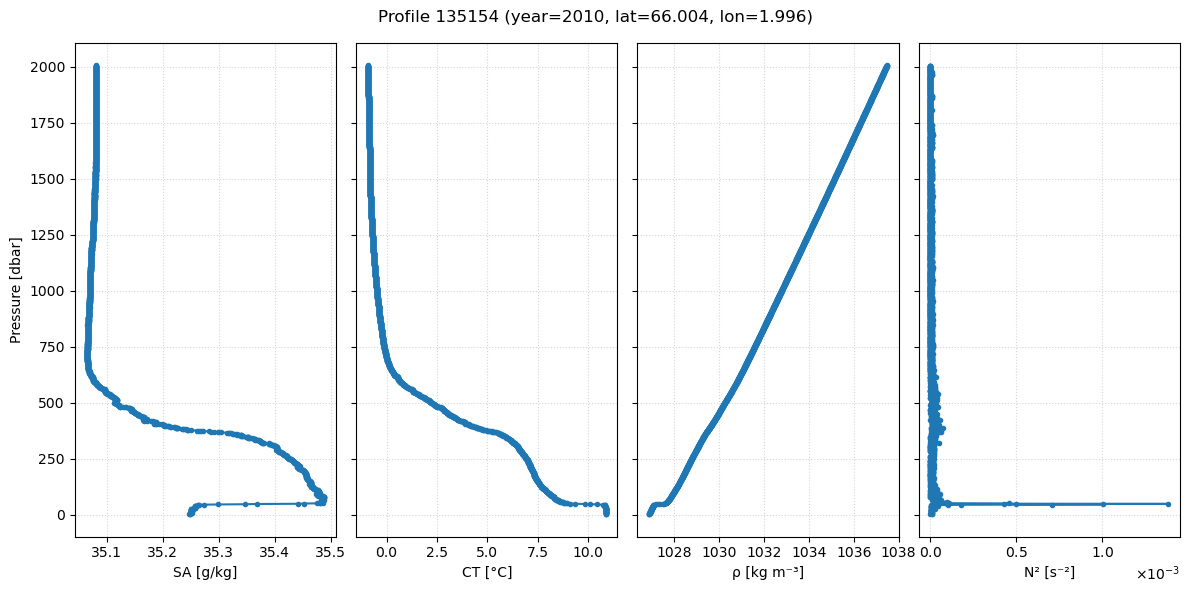

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from pathlib import Path


year = 2010            
profile_id = 135154       

# Load UDASH file for that year
UDASH_FILE = Path(f"UDASH/ArcticOcean_phys_oce_{year}.txt")
TEOS_DIR = Path("Density")

# CHATGPT: ensures you get the correct TEOS-10 file associated with the UDASH file by searching for a pattern
pattern_teos = f"*_{UDASH_FILE.stem}_teos10.txt"
teos_files = sorted(TEOS_DIR.glob(pattern_teos))
if not teos_files:
    raise FileNotFoundError(f"No TEOS-10 file matching {pattern_teos}")

TEOS10_FILE = teos_files[0]
df_teos10 = pd.read_csv(TEOS10_FILE, sep="\t")

# CHATGPT: Load N2 file for that year the same way like the TEOS-10 file
N2_DIR = Path("N2")
n2_file = N2_DIR / f"N2_{year}_{UDASH_FILE.stem}.txt"
if not n2_file.exists():
    raise FileNotFoundError(f"N2 file not found: {n2_file}")

dfN2 = pd.read_csv(n2_file, sep="\t")

# Select the chosen cast from both files
g_teos = (
    df_teos10[df_teos10["Prof_no"] == profile_id]
    .sort_values("Pressure_[dbar]")
)

g_n2 = (
    dfN2[dfN2["Prof_no"] == profile_id]
    .sort_values("Pressure_[dbar]")
)

# Give a warning if one file doesnt have that cast
if g_teos.empty:
    raise RuntimeError(f"Cast {profile_id} not found in TEOS-10 file for year {year}")

if g_n2.empty:
    raise RuntimeError(f"Cast {profile_id} not found in N2 file for year {year}")

# Extract variables and make them into float agsin
p = g_teos["Pressure_[dbar]"].to_numpy()
SA = g_teos["Absolute_Salinity_g_kg"].to_numpy()
CT = g_teos["Conservative_Temp_degC"].to_numpy()
rho = g_teos["Density_kg_m3"].to_numpy()

p_mid = g_n2["Pressure_[dbar]"].to_numpy()
N2v = g_n2["N2_[s^-2]"].to_numpy()

# Plot
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

axes[0].plot(SA, p, marker=".")
axes[0].set_xlabel("SA [g/kg]")
axes[0].set_ylabel("Pressure [dbar]")

axes[1].plot(CT, p, marker=".")
axes[1].set_xlabel("CT [°C]")

axes[2].plot(rho, p, marker=".")
axes[2].set_xlabel("ρ [kg m⁻³]")

axes[3].plot(N2v, p_mid, marker=".")
axes[3].set_xlabel("N² [s⁻²]")

# I prefer scientific notation for the buoyancy frequencies
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
axes[3].xaxis.set_major_formatter(formatter)
axes[3].ticklabel_format(style="sci", axis="x", scilimits=(0, 3))

# Inverts the axis because pressure and depth are inversely related
for ax in axes:
    ax.invert_yaxis()
    ax.grid(True, linestyle=":", alpha=0.5)

# Lat & Lon of the FIRST measurement per cast
lat = g_teos["Latitude_[deg]"].iloc[0]
lon = g_teos["Longitude_[deg]"].iloc[0]

fig.suptitle(
    f"Profile {profile_id} (year={year}, lat={lat:.3f}, lon={lon:.3f})",
    y=0.98
)

plt.tight_layout()
plt.show()


For one cast (one Prof_no) this code takes the mid-point depths and N2 from dfN2 (Depth_[m], N2_[s^-2] for that Prof_no and year), then does a check to only proceed if N2_QC_flag is at least 1 or 2.

Afterwards I define a regular depth grid (e.g. Δz = 5–10 m or the median native Δz) which I can simply adapt on the go.

Finally to interpolate N²(z) from the irregular z_mid to the regular z_reg, so as not only to have the pressure plot as above.

Preparing cast Prof_no=135154 (year=2010) for EVP
  N2_QC_flag = 2, depth_range = 1971.8 m, max_gap = 1.0 m
  Regular grid: 1975 levels, dz ≈ 1.00 m
  Time: 2010-10-03 21:04:00  (month=10)


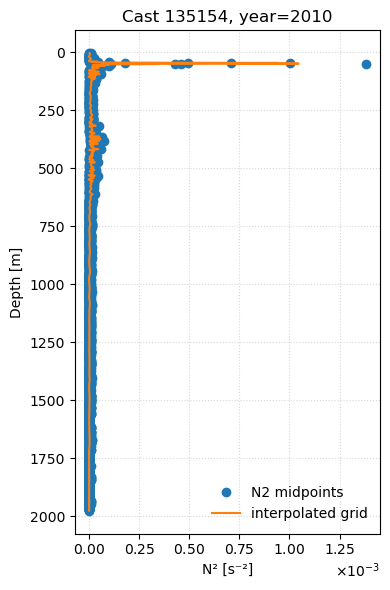

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import ScalarFormatter



year = 2010           # year of interest
profile_id = 135154      # Prof_no to prepare for EVP
dz_target = None      # if None -> use median native Δz; else set as one likes

# Load N2 file for that year
UDASH_FILE = Path(f"UDASH/ArcticOcean_phys_oce_{year}.txt")
N2_DIR = Path("N2")
n2_file = N2_DIR / f"N2_{year}_{UDASH_FILE.stem}.txt"

# Error if that file doesnt exit
if not n2_file.exists():
    raise FileNotFoundError(f"N2 file not found: {n2_file}")

dfN2 = pd.read_csv(n2_file, sep="\t")

# Cast out the non-casted casts to keep the casted cast
g = (
    dfN2[dfN2["Prof_no"] == profile_id]
    .sort_values("Depth_[m]")
    .dropna(subset=["Depth_[m]", "N2_[s^-2]"])
)

# Cast-check the cast table. If the casted cast is castless, cast a RuntimeError for the cast-year.
if g.empty:
    raise RuntimeError(f"Cast {profile_id} not found in N2 file for year {year}")

# QC info since it´s best to just ignore the 0´s
qc_flag = g["N2_QC_flag"].iloc[0] if "N2_QC_flag" in g.columns else np.nan
depth_range = g["Depth_range_[m]"].iloc[0] if "Depth_range_[m]" in g.columns else np.nan
max_gap = g["Max_gap_[m]"].iloc[0] if "Max_gap_[m]" in g.columns else np.nan

print(f"Preparing cast Prof_no={profile_id} (year={year}) for EVP")
print(f"  N2_QC_flag = {qc_flag}, depth_range = {depth_range:.1f} m, max_gap = {max_gap:.1f} m")

# Native mid-point depth and N2 to float
z_mid = g["Depth_[m]"].to_numpy(float)
N2_mid = g["N2_[s^-2]"].to_numpy(float)

# Ensure we have enough levels per cast to yield a physically meaningful profile
if z_mid.size < 3:
    raise RuntimeError("Too few N² levels to build a useful regular grid.")

# Define regular depth grid from the mid-depths as is intrinsic to Chelton and the gsw function
dz_native = np.diff(z_mid)
dz_med = float(np.median(dz_native)) if dz_native.size > 0 else np.nan

# Define substitution seperation
if dz_target is None:
    dz = dz_med
else:
    dz = float(dz_target)

if not np.isfinite(dz) or dz <= 0:
    raise RuntimeError(f"Could not determine a positive dz (dz_native_med = {dz_med})")

zmin, zmax = float(z_mid.min()), float(z_mid.max())
z_reg = np.arange(zmin, zmax + 0.5 * dz, dz)  # include top & bottom

# Interpolate N2 onto regular grid how I learned it
#N2_reg = np.interp(z_reg, z_mid, N2_mid)

# CHATGPT
# Interpolate N2 onto regular grid with a smooth spline
# s = 0 -> passes exactly through the data (already much smoother than np.interp)
# increase s for more smoothing, e.g. s=len(z_mid)*np.var(N2_mid)*0.1
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(z_mid, N2_mid, s=0.00000005)
N2_reg = spline(z_reg)


# Grab metadata (lat, lon, time, month) from the first part of the cast
lat = float(g["Latitude_[deg]"].iloc[0])
lon = float(g["Longitude_[deg]"].iloc[0])

cast_time = None
cast_month = None
if "yyyy-mm-ddThh:mm" in g.columns:
    try:
        cast_time = pd.to_datetime(g["yyyy-mm-ddThh:mm"].iloc[0])
        cast_month = cast_time.month
    except Exception:
        pass

print(f"  Regular grid: {z_reg.size} levels, dz ≈ {dz:.2f} m")
if cast_month is not None:
    print(f"  Time: {cast_time}  (month={cast_month})")

# Quick diagnostic plot: pointwise vs interpolated N2
fig, ax = plt.subplots(figsize=(4, 6))

ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 2))

ax.plot(N2_mid, z_mid, "o", label="N2 midpoints")
ax.plot(N2_reg, z_reg, "-", label="interpolated grid")
ax.invert_yaxis()
ax.set_xlabel("N² [s⁻²]")
ax.set_ylabel("Depth [m]")
ax.grid(True, linestyle=":", alpha=0.5)
ax.legend(frameon=False)
ax.set_title(f"Cast {profile_id}, year={year}")

plt.tight_layout()
plt.show()

# z_reg and N2_reg are now ready for EVP (Step 4–5)


I am thinking that an uncertainty calculation is needed due to the error propagation. Perhaps the MAD-based Method found in the Git Repository of Pollmann et.al. can be adapted to this here?

It is furthermore worthwile to retrieve an overall profile for a given year, despite seasonal variations, just to make sure it overall behaves somewhat physical.

Year 2010: 5356 casts with N2_QC_flag >= 2
Included 5356 casts in the average profile.


/tmp/ipykernel_28586/533555326.py:74: RuntimeWarning: Mean of empty slice
  mean_N2 = np.nanmean(N2_stack, axis=0)
/home/conda/envs/ocean/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1216: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


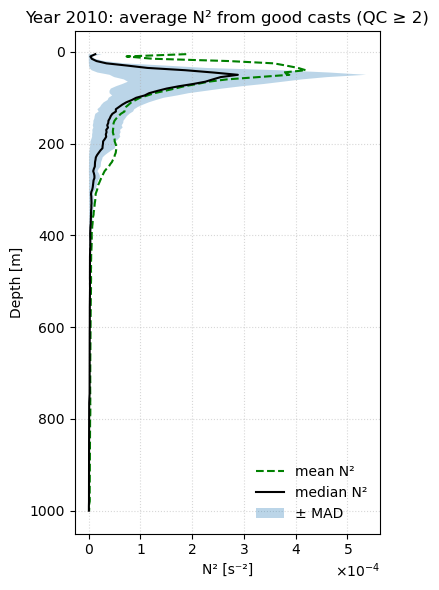

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


# SETTINGS
year = 2010           # year to process
qc_min = 2            # minimum N2_QC_flag to accept
z_min = 0.0           # depth range for common grid [m]
z_max = 1000.0         # "
dz = 5.0              # grid spacing [m]

# Load N2 file for that year
UDASH_FILE = Path(f"UDASH/ArcticOcean_phys_oce_{year}.txt")
N2_DIR = Path("N2")
n2_file = N2_DIR / f"N2_{year}_{UDASH_FILE.stem}.txt"

if not n2_file.exists():
    raise FileNotFoundError(f"N2 file not found: {n2_file}")

dfN2 = pd.read_csv(n2_file, sep="\t")

# Select "good" casts by QC flag
if "N2_QC_flag" not in dfN2.columns:
    raise RuntimeError("Column 'N2_QC_flag' not found. "
                       "Make sure you ran the QC-aware N² cell.")

good = dfN2[dfN2["N2_QC_flag"] >= qc_min].copy()
if good.empty:
    raise RuntimeError(f"No casts with N2_QC_flag >= {qc_min} for year {year}.")

# Retain the approved cast id´s
cast_ids = good["Prof_no"].unique()
print(f"Year {year}: {len(cast_ids)} casts with N2_QC_flag >= {qc_min}")

# Build common depth grid at the midpoints
z_grid = np.arange(z_min, z_max + dz/2, dz)
nz = z_grid.size

# Matrix to hold N2(z) per cast on common grid
N2_stack = []

# Loop that checks each N2 wether it is in an approved cast and then turns it into float
for cid in cast_ids:
    g = (
        good[good["Prof_no"] == cid]
        .sort_values("Depth_[m]")
        .dropna(subset=["Depth_[m]", "N2_[s^-2]"])
    )
    if g.empty or g["Depth_[m]"].nunique() < 3:
        continue

    z_mid = g["Depth_[m]"].to_numpy(float)
    N2_mid = g["N2_[s^-2]"].to_numpy(float)

# interpolate to z_grid and set values outside native range to NaN
    z_lo, z_hi = z_mid.min(), z_mid.max()
    N2_interp = np.interp(z_grid, z_mid, N2_mid)
    mask_outside = (z_grid < z_lo) | (z_grid > z_hi)
    N2_interp[mask_outside] = np.nan

    N2_stack.append(N2_interp)

# We cant interpolate if there is nothing to interpolate
N2_stack = np.array(N2_stack)
if N2_stack.size == 0:
    raise RuntimeError("No valid casts for interpolation on common grid.")

print(f"Included {N2_stack.shape[0]} casts in the average profile.")

# Compute average profiles (mean, median, MAD) as in Pinner et al 2025
mean_N2 = np.nanmean(N2_stack, axis=0)
median_N2 = np.nanmedian(N2_stack, axis=0)
mad_N2 = np.nanmedian(np.abs(N2_stack - median_N2), axis=0)

# Plot average N2 profiles
fig, ax = plt.subplots(figsize=(4, 6))


ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 2))


ax.plot(mean_N2, z_grid, "g--", label="mean N²")
ax.plot(median_N2, z_grid, "k-", label="median N²")

# show MAD envelope
ax.fill_betweenx(
    z_grid,
    median_N2 - mad_N2,
    median_N2 + mad_N2,
    alpha=0.3,
    label="± MAD"
)

ax.invert_yaxis()
ax.set_xlabel("N² [s⁻²]")
ax.set_ylabel("Depth [m]")
ax.grid(True, linestyle=":", alpha=0.5)
ax.legend(frameon=False)
ax.set_title(f"Year {year}: average N² from good casts (QC ≥ {qc_min})")

plt.tight_layout()
plt.show()

# If you want to keep the average profile as a DataFrame:
#dfN2_avg = pd.DataFrame({
#    "Depth_[m]": z_grid,
#    "mean_N2_[s^-2]": mean_N2,
#    "median_N2_[s^-2]": median_N2,
#    "MAD_N2_[s^-2]": mad_N2,
#})


# 2. Creating the Eigenvalue Problem

This will need a few days of literature recherche and reading into, as we are now entering the not so well documented realms. PDF sources are stored locally again

Non PDF Sources:
- https://gist.github.com/douglatornell/5479638
- https://github.com/OceanLabPy/OceanLab/blob/master/examples/DYN_EOF.ipynb    (not this example, but maybe DYN.vmodes(...)
- https://github.com/UBC-MOAD/AIMS-Workshop/blob/main/dynmodes/dynmodes.ipynb   (is a newer refined version, could be changed to work)
- "Fast and Accurate Computation of Vertical Modes" Early et.al. 2020 could help too, since I literally have worked with spectral methods and Chebyshev Polynomials befor
- Chelton et.al. 1998 still is really helpful
- "The Vertical Mode Decomposition of Surface and Internal Tides in the Presence of a Free Surface and Arbitrary Topography" by Samuel L. Kelly 2016, although here I wonder if his assumptions even remotely agree with mine


Furthermore, the large errors and variations of the Buoyancy Frequency in the upper meters call for caution due to error propagation.

Single EVP solved for cast Prof_no=327, year=2012
Depth range: 4.5–36.5 m, dz ≈ 1.00 m
Computed 5 modes (eigenspeeds):
  Mode 1: c_n = 0.509 m/s
  Mode 2: c_n = 0.182 m/s
  Mode 3: c_n = 0.111 m/s
  Mode 4: c_n = 0.082 m/s
  Mode 5: c_n = 0.067 m/s


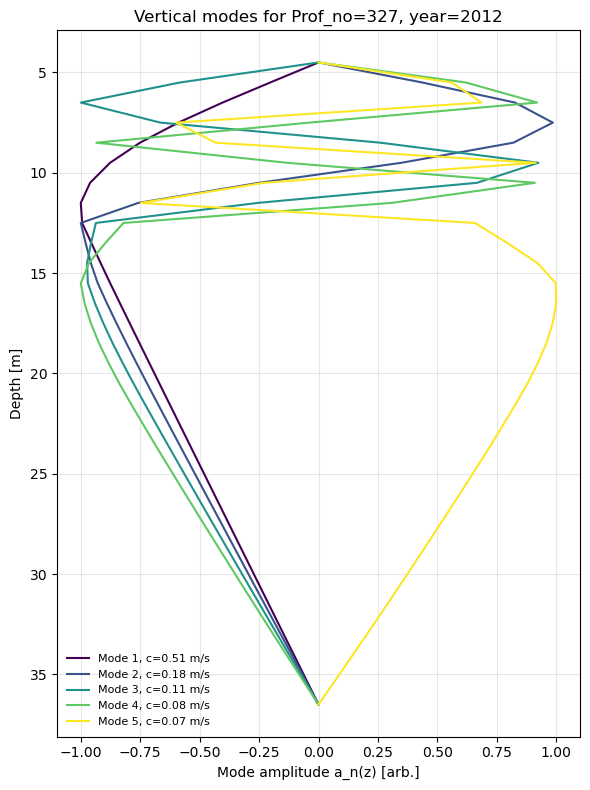

In [33]:
import numpy as np          # numerical library for arrays, linear algebra, etc.
import pandas as pd         # tabular data handling (here: dfN2 with N² profiles)
import matplotlib.pyplot as plt  # plotting library for the vertical modes

# ------------------------------------------------------------
# REQUIREMENT: dfN2 must already exist from your N² computation
#   needed columns: 'Prof_no', 'Depth_[m]', 'N2_[s^-2]'
#
# Conceptually:
# - dfN2 is assumed to contain buoyancy frequency squared N²(z) for many casts.
# - This N²(z) is the key input to the vertical eigenvalue problem (EVP),
#   as in classic mode-decomposition / Sturm–Liouville formulations
#   used by Chelton et al. (1998) for Rossby radii and by
#   Pollmann et al., Early (2015), Kelly et al. (2016) for internal-tide modes.
# ------------------------------------------------------------
if "dfN2" not in globals():   # check that dfN2 is already defined in the notebook
    raise RuntimeError("dfN2 not found. Run the N² computation cell first.")

# ------------------------------------------------------------
# 1) Choose a cast (profile) to solve Pollmann's EVP for
#    -> change profile_id to the Prof_no you care about (e.g. 490)
#
# Here, 'Prof_no' identifies individual hydrographic profiles (casts),
# similar to how Chelton et al. (1998) or Kelly et al. (2016) select
# individual stations to solve for vertical modes.
# Pollmann et al. also solve an EVP per profile to get local vertical modes.
# ------------------------------------------------------------
profile_id = 327            # here we explicitly pick cast 523; change manually if desired
year = 2012

# subset dfN2 to just this one cast
g = dfN2[dfN2["Prof_no"] == profile_id].copy()
# remove rows where depth or N² is missing (we need paired depth–N² for the EVP)
g = g.dropna(subset=["Depth_[m]", "N2_[s^-2]"])

# sanity check: we need at least a few points to construct a vertical profile
if len(g) < 5:
    raise RuntimeError(f"Not enough N² points for profile {profile_id}.")

# try to infer year from timestamp column (if present)
# This is just metadata extraction: it allows us to label the result
# with the year of observation, which is useful for temporal analyses
# (e.g. comparing years as in climate / variability studies).

if "yyyy-mm-ddThh:mm" in g.columns:
    try:
        year = pd.to_datetime(g["yyyy-mm-ddThh:mm"].iloc[0]).year
    except Exception:
        year = None

# sort by depth so that the profile goes from shallow to deep,
# which is required for consistent finite-difference stencils in z.
g = g.sort_values("Depth_[m]")
z_raw = g["Depth_[m]"].to_numpy(float)      # depth array [m]
N2_raw = g["N2_[s^-2]"].to_numpy(float)    # buoyancy frequency squared N²(z) [s^-2]

# require strictly increasing depth (no duplicates or inversions),
# because the second-derivative operator assumes a monotonic grid.
if np.any(np.diff(z_raw) <= 0):
    raise RuntimeError("Depths are not strictly increasing for this cast.")

# ------------------------------------------------------------
# 2) Build a regular depth grid and interpolate N²(z) onto it
#
# The EVP is discretized on a uniform vertical grid Δz, so we:
#   - estimate an appropriate Δz from the observed depth spacing,
#   - build a regular grid,
#   - interpolate N²(z) onto this grid.
#
# This follows the standard approach in oceanic vertical-mode theory:
# see e.g. Chelton et al. (1998) and Early (2015), where N² is
# interpolated onto a uniform z-grid before solving for modes.
# ------------------------------------------------------------
zmin, zmax = z_raw.min(), z_raw.max()     # minimum and maximum observed depths
dz_est = np.median(np.diff(z_raw))       # "typical" vertical spacing from the data

if dz_est <= 0:
    raise RuntimeError("Could not estimate a positive dz for the grid.")

# construct a regular depth grid from zmin to zmax with spacing ≈ dz_est
z_reg = np.arange(zmin, zmax + dz_est, dz_est)

# linearly interpolate N² from the irregular raw grid to the regular grid
# left/right=NaN ensures we don't extrapolate beyond the data range.
N2_reg = np.interp(z_reg, z_raw, N2_raw, left=np.nan, right=np.nan)

# ensure positive N² (avoid zero or negative values which would break the
# weighted Sturm–Liouville formulation). We clip to a small positive floor
# (1e-8 s^-2) as is commonly done in practice when N² is nearly zero.
N2_reg = np.clip(N2_reg, 1e-8, np.inf)

# ------------------------------------------------------------
# 3) Discretize Pollmann EVP:
#      d²a/dz² + N²(z)/c_n² * a = 0
#  -> -a'' = λ N²(z) a,  λ = 1/c_n²
#
#  We impose Dirichlet BCs: a(0)=a(H)=0
#  using second-order finite differences on interior points.
#
# This is the standard vertical-mode Sturm–Liouville problem used in:
#   - Chelton et al. (1998): to define baroclinic modes and Rossby radii.
#   - Early (2015): fast and accurate computation of vertical modes.
#   - Kelly et al. (2016): modes for internal tides and mesoscale flows.
#   - Pollmann et al.: specific Pollmann normalization and use for internal tides.
#
# Here we follow the formulation used in Pollmann's Eq. (8–10),
# where N²(z) appears as a weight, and c_n is the eigen-speed.
# ------------------------------------------------------------
dz = z_reg[1] - z_reg[0]    # uniform vertical grid spacing
nz = z_reg.size             # total number of grid points (including boundaries)
nint = nz - 2               # number of interior grid points (excluding top & bottom)

if nint < 1:
    raise RuntimeError("Grid too short for interior points.")

# second-derivative matrix D2 on interior points
# This constructs a standard 3-point finite-difference approximation to d²/dz²
# with Dirichlet boundary conditions (a=0 at top and bottom, so boundary
# values do not appear explicitly in the interior operator).
D2 = np.zeros((nint, nint))
coef = 1.0 / dz**2          # coefficient 1/Δz² for the second derivative

for i in range(nint):
    D2[i, i] = -2.0 * coef      # central point
    if i > 0:
        D2[i, i - 1] = coef     # one step up in depth
    if i < nint - 1:
        D2[i, i + 1] = coef     # one step down in depth

# generalized eigenproblem: A a = λ B a
#   A = -D2 (discretized -d²/dz² operator)
#   B = diag(N²_int) (diagonal matrix with N²(z) as weights)
#   λ = 1/c_n²  (eigenvalue related to inverse squared mode speed)
#
# This is directly analogous to formulations in Chelton et al. (1998)
# and Kelly et al. (2016), where λ_n is inversely related to c_n² and
# c_n is the baroclinic mode speed.
A = -D2
N2_int = N2_reg[1:-1]                     # interior N² values (matching nint)
N2_int_clipped = np.clip(N2_int, 1e-8, np.inf)  # ensure strictly positive weights

# convert to standard symmetric EVP: C y = λ y  with C = B^{-1/2} A B^{-1/2}
# This transformation is used because:
#   - A a = λ B a is a generalized eigenproblem.
#   - By writing a = B^{-1/2} y, we obtain:
#       C y = λ y,  where C = B^{-1/2} A B^{-1/2},
#     which is symmetric and positive-definite under suitable conditions.
#
# This symmetric formulation allows us to use np.linalg.eigh, which assumes
# a Hermitian (symmetric real) matrix and yields orthogonal eigenvectors,
# consistent with the theory in Early (2015) and Pollmann's normalization ideas.
s = np.sqrt(N2_int_clipped)                  # s = N²^{1/2} on interior points, i.e. B^{1/2}
C = (A / s[np.newaxis, :]) / s[:, np.newaxis]  # element-wise transform to form C = B^{-1/2} A B^{-1/2}

# solve the symmetric eigenvalue problem C y = λ y
# eigvals: λ_n, eigvecs: y_n
eigvals, eigvecs = np.linalg.eigh(C)

# sort eigenvalues/eigenvectors
# We want modes ordered from smallest λ (largest c_n) to largest λ (smallest c_n),
# which corresponds to the standard ordering of vertical baroclinic modes
# (mode 1, mode 2, etc.) seen in Chelton et al., Kelly et al., and Pollmann.
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# keep only positive eigenvalues
# Negative or zero λ would correspond to non-physical or numerically noisy modes
# (e.g. due to clipping or roundoff). Physically, λ = 1/c_n² > 0 for real c_n.
lambda_n = eigvals[eigvals > 0]
eigvecs = eigvecs[:, eigvals > 0]

# ------------------------------------------------------------
# 4) Eigen-speeds c_n and vertical eigenfunctions a_n(z)
#
# From λ_n = 1/c_n², we compute:
#   c_n = 1 / sqrt(λ_n),
# which are the Pollmann-type "eigenspeeds" (baroclinic mode speeds).
#
# These are directly analogous to the mode speeds in Chelton et al. (1998),
# which they use to define the first baroclinic Rossby radius, and to the
# internal-tide mode speeds in Kelly et al. (2016) and Pollmann et al.
#
# We also reconstruct the vertical mode shapes a_n(z) from y_n via:
#   a = B^{-1/2} y = y / sqrt(N²),
# which yields the depth-dependent eigenfunctions that describe how
# each baroclinic mode varies with depth (as in all these papers).
# ------------------------------------------------------------
cn = 1.0 / np.sqrt(lambda_n)  # Pollmann eigenspeeds (one number per mode)
nmodes = min(5, cn.size)      # number of modes to keep / plot (here: first 5 modes max)

# allocate array for full-depth mode shapes: (nz vertical levels) × (nmodes)
modes = np.zeros((nz, nmodes))
for n in range(nmodes):
    y = eigvecs[:, n]         # eigenvector in y-space (solution of C y = λ y)
    a_int = y / s             # recover a on interior points: a = B^{-1/2} y = y / sqrt(N²)
    modes[1:-1, n] = a_int    # insert interior a(z) into full column (boundaries fixed at 0)

    # normalize mode n so max |a| = 1 (arbitrary amplitude normalization).
    # Pollmann uses a weighted norm, but for plotting and qualitative comparison
    # often a simple max|a|=1 scaling is sufficient (and is common practice
    # in mode plots such as in Early 2015 and Chelton-style figures).
    modes[:, n] /= np.max(np.abs(modes[:, n]))

# ------------------------------------------------------------
# 5) Summary + plot
#
# This summarizes the solution for this one cast and plots the vertical
# mode shapes a_n(z), colored by mode number, together with their corresponding
# baroclinic eigen-speeds c_n.
#
# Such plots are directly comparable to classical figures of baroclinic
# modes and internal-tide modes in:
#   - Chelton et al. (1998): first baroclinic mode structure.
#   - Early (2015): examples of vertical modes for various stratifications.
#   - Kelly et al. (2016), Pollmann et al.: mode shapes and speeds used in
#     internal-tide generation and propagation studies.
# ------------------------------------------------------------
year_str = f", year={year}" if year is not None else ""
print(f"Single EVP solved for cast Prof_no={profile_id}{year_str}")
print(f"Depth range: {z_reg.min():.1f}–{z_reg.max():.1f} m, dz ≈ {dz:.2f} m")
print(f"Computed {nmodes} modes (eigenspeeds):")
for n in range(nmodes):
    print(f"  Mode {n+1}: c_n = {cn[n]:.3f} m/s")

fig, ax = plt.subplots(figsize=(6, 8))
colors = plt.cm.viridis(np.linspace(0, 1, nmodes))
for n in range(nmodes):
    # plot each mode's vertical structure a_n(z) vs depth
    ax.plot(modes[:, n], z_reg, color=colors[n],
            label=f"Mode {n+1}, c={cn[n]:.2f} m/s")

# invert y-axis so that 0 m is at the top and deeper water is lower on the plot,
# following the oceanographic convention used in Chelton-like and Pollmann-like figures.
ax.invert_yaxis()
ax.set_xlabel("Mode amplitude a_n(z) [arb.]")  # dimensionless mode shape
ax.set_ylabel("Depth [m]")
ax.set_title(f"Vertical modes for Prof_no={profile_id}{year_str}")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8, frameon=False, loc="best")
plt.tight_layout()
plt.show()


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================
# REQUIREMENT:
#   dfN2 must exist with at least:
#   ["Prof_no", "Latitude_[deg]", "Longitude_[deg]",
#    "Depth_[m]", "N2_[s^-2]"]
#   (and ideally "yyyy-mm-ddThh:mm" for year tagging)
# ============================================================
if "dfN2" not in globals():
    raise RuntimeError("dfN2 not found. Run the N² computation cell first.")

# Base output folder
base_outdir = Path("eigenspeeds")
base_outdir.mkdir(parents=True, exist_ok=True)

# Global M2 frequency for vertical phase speed
omega_M2 = 2.0 * np.pi / (12.42 * 3600.0)  # [rad/s]

# ------------------------------------------------------------
# Function to solve Pollmann EVP for one cast
# ------------------------------------------------------------
def solve_pollmann_evp(z_raw, N2_raw):
    """Solve d²a/dz² + N²/c² * a = 0 with Dirichlet BCs for one profile."""
    # Regularize grid
    zmin, zmax = z_raw.min(), z_raw.max()
    dz_est = np.median(np.diff(z_raw))
    z_reg = np.arange(zmin, zmax + dz_est, dz_est)
    N2_reg = np.interp(z_reg, z_raw, N2_raw)
    N2_reg = np.clip(N2_reg, 1e-8, np.inf)

    dz = z_reg[1] - z_reg[0]
    nz = z_reg.size
    nint = nz - 2
    if nint < 2:
        return None, None, None, None

    # second-derivative operator with Dirichlet BCs
    D2 = np.zeros((nint, nint))
    coef = 1.0 / dz**2
    for i in range(nint):
        D2[i, i] = -2.0 * coef
        if i > 0:
            D2[i, i - 1] = coef
        if i < nint - 1:
            D2[i, i + 1] = coef

    A = -D2
    N2_int = N2_reg[1:-1]
    N2_int_clipped = np.clip(N2_int, 1e-8, np.inf)
    s = np.sqrt(N2_int_clipped)
    C = (A / s[np.newaxis, :]) / s[:, np.newaxis]

    eigvals, eigvecs = np.linalg.eigh(C)
    idx = np.argsort(eigvals)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Keep positive eigenvalues only
    mask = eigvals > 0
    eigvals, eigvecs = eigvals[mask], eigvecs[:, mask]
    if eigvals.size == 0:
        return None, None, None, None

    cn = 1.0 / np.sqrt(eigvals)
    nmodes = min(5, cn.size)

    # Reconstruct full mode shapes
    modes = np.zeros((nz, nmodes))
    for n in range(nmodes):
        y = eigvecs[:, n]
        a_int = y / s
        modes[1:-1, n] = a_int
        modes[:, n] /= np.max(np.abs(modes[:, n]))  # simple normalization

    return z_reg, N2_reg, cn[:nmodes], modes[:, :nmodes]

# ------------------------------------------------------------
# Loop through all casts
# ------------------------------------------------------------
unique_casts = dfN2["Prof_no"].unique()
print(f"Solving Pollmann EVP for {len(unique_casts)} casts...")

for cid in unique_casts:
    cast = dfN2[dfN2["Prof_no"] == cid].dropna(subset=["Depth_[m]", "N2_[s^-2]"])
    if len(cast) < 5:
        continue

    # infer year for this cast (from timestamp column if present)
    year_tag = "unknown"
    if "yyyy-mm-ddThh:mm" in cast.columns:
        try:
            year_tag = str(pd.to_datetime(cast["yyyy-mm-ddThh:mm"].iloc[0]).year)
        except Exception:
            year_tag = "unknown"

    # per-year subfolder
    outdir = base_outdir / year_tag
    outdir.mkdir(parents=True, exist_ok=True)

    # sort by depth
    z_raw = cast["Depth_[m]"].to_numpy(float)
    N2_raw = cast["N2_[s^-2]"].to_numpy(float)
    order = np.argsort(z_raw)
    z_raw, N2_raw = z_raw[order], N2_raw[order]

    z, N2_prof, cn, modes = solve_pollmann_evp(z_raw, N2_raw)
    if z is None:
        continue

    nmodes = modes.shape[1]
    lat = float(cast["Latitude_[deg]"].iloc[0])
    lon = float(cast["Longitude_[deg]"].iloc[0])

    # ---------- Depth-dependent vertical phase speed from EVP + N² ----------
    N2_arr = N2_prof.astype(float)
    vertical_phase_speed = np.full((z.size, nmodes), np.nan)
    arg = N2_arr - omega_M2**2  # only real where N² > ω²

    mask = arg > 0.0
    for n in range(nmodes):
        vertical_phase_speed[mask, n] = omega_M2 * cn[n] / np.sqrt(arg[mask])

    # ---------- Save as TXT ----------
    out_txt = outdir / f"{year_tag}_cast_{int(cid)}_eigenspeeds.txt"
    header = (
        "Year\tProf_no\tLatitude_[deg]\tLongitude_[deg]\tDepth_[m]\tN2_[s^-2]\t"
        "Mode\tEigenfunction_a_n(z)\tEigenspeed_c_n_[m/s]\tVerticalPhaseSpeed_[m/s]"
    )

    with open(out_txt, "w") as f:
        f.write(header + "\n")
        for n in range(nmodes):
            for zi, N2i, ai, cvert in zip(z, N2_prof, modes[:, n], vertical_phase_speed[:, n]):
                f.write(
                    f"{year_tag}\t{int(cid)}\t{lat:.6f}\t{lon:.6f}\t{zi:.3f}\t{N2i:.6e}\t"
                    f"{n+1}\t{ai:.6e}\t{cn[n]:.6f}\t{cvert:.6e}\n"
                )
    # print(f"Saved {out_txt.name} in {outdir}")

    # ---------- Plot and save PNG ----------
    fig, ax = plt.subplots(figsize=(6, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, nmodes))
    for n in range(nmodes):
        ax.plot(modes[:, n], z, color=colors[n], label=f"Mode {n+1}, c={cn[n]:.2f} m/s")
    ax.invert_yaxis()
    ax.set_xlabel("Mode amplitude a_n(z)")
    ax.set_ylabel("Depth [m]")
    ax.set_title(f"Pollmann EVP: Cast {cid}, year={year_tag}\n({lat:.2f}°N, {lon:.2f}°E)")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, frameon=False, loc="best")
    fig.tight_layout()

    out_png = outdir / f"{year_tag}_cast_{int(cid)}_modes.png"
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.close(fig)

print(f"All results saved in folder tree: {base_outdir.resolve()}")



Solving Pollmann EVP for 6235 casts...
All results saved in folder tree: /home/rill/eigenspeeds


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================
# REQUIREMENT:
#   dfN2 must exist with at least:
#   ["Prof_no", "Latitude_[deg]", "Longitude_[deg]",
#    "Depth_[m]", "N2_[s^-2]"]
#   (and ideally "yyyy-mm-ddThh:mm" for year tagging)
#
# Physically: dfN2 contains N²(z) profiles (buoyancy frequency
# squared) for many hydrographic casts. The vertical modes of
# internal waves / internal tides are solutions of a Sturm–Liouville
# eigenvalue problem with N²(z) as the "potential" (weight) function.
# This is exactly the framework used by Chelton et al. (1998) to
# compute baroclinic phase speeds and Rossby radii, and by Pollmann
# & Nycander (2023) to define the eigenproblem for internal-tide
# generation (eq. 8 in their paper). 
# ============================================================
if "dfN2" not in globals():
    raise RuntimeError("dfN2 not found. Run the N² computation cell first.")

# Base output folder
base_outdir = Path("eigenspeeds")
base_outdir.mkdir(parents=True, exist_ok=True)

# Global M2 frequency for vertical phase speed
omega_M2 = 2.0 * np.pi / (12.42 * 3600.0)  # [rad/s]
# M2: principal lunar semidiurnal tide.
# The angular frequency ω_M2 is used later when we convert from
# (vertical mode speed c_n and local N²) to a frequency-dependent,
# depth-varying "vertical phase speed" via a simple internal-wave
# dispersion relation approximation. Pollmann & Nycander (2023)
# also focus specifically on the M2 tide in their global application. 

# ------------------------------------------------------------
# Function to solve Pollmann EVP for one cast
# ------------------------------------------------------------
def solve_pollmann_evp(z_raw, N2_raw):
    """
    Solve d²a/dz² + N²(z)/c² * a = 0 with Dirichlet BCs for one profile.

    This is the same *type* of vertical eigenvalue problem as
    in Chelton et al. (1998, their eq. 2.1a–c) and Pollmann & Nycander (2023, eq. 8),
    i.e.:
        d²a_n/dz² + N²(z)/c_n² * a_n = 0,   with a_n(0) = a_n(-H) = 0.
    In Sturm–Liouville form this is:
        -a_n'' = λ_n N²(z) a_n,   λ_n = 1/c_n².
    We discretize this with second-order finite differences, which is the
    "standard" approach described in textbooks and in the numerical discussion
    by Early et al. (2020), even though they recommend higher-order/spectral
    schemes for many modes. 
    """
    # Regularize grid: build a nearly uniform vertical grid from the
    # irregular sampling depths. This is analogous to what Chelton et al.
    # do with climatological T/S profiles before solving their EVP. :contentReference[oaicite:4]{index=4}
    zmin, zmax = z_raw.min(), z_raw.max()
    dz_est = np.median(np.diff(z_raw))
    z_reg = np.arange(zmin, zmax + dz_est, dz_est)
    # Interpolate measured N² onto the regular grid
    N2_reg = np.interp(z_reg, z_raw, N2_raw)
    # Clip to positive values to avoid singular weight matrix B ~ N²
    N2_reg = np.clip(N2_reg, 1e-8, np.inf)

    # Basic grid parameters
    dz = z_reg[1] - z_reg[0]
    nz = z_reg.size
    nint = nz - 2  # number of interior points (excluding top & bottom BCs)
    if nint < 2:
        # Need at least two interior levels for a meaningful second derivative
        return None, None, None, None

    # --------------------------------------------------------
    # second-derivative operator with Dirichlet BCs
    #
    # We build the classic tri-diagonal finite-difference approximation
    # to d²/dz² on the interior points, with a(0)=a(H)=0 enforced by
    # omission of the boundary nodes. This is exactly the structure of
    # the "standard finite-difference" operator discussed by Early et al.
    # as the baseline method. :contentReference[oaicite:5]{index=5}
    # --------------------------------------------------------
    D2 = np.zeros((nint, nint))
    coef = 1.0 / dz**2
    for i in range(nint):
        D2[i, i] = -2.0 * coef
        if i > 0:
            D2[i, i - 1] = coef
        if i < nint - 1:
            D2[i, i + 1] = coef

    # generalized eigenproblem: A a = λ B a
    #   A = -D2 (discrete -d²/dz² on interior)
    #   B = diag(N²_int)
    # so that λ = 1/c_n², consistent with Pollmann’s notation. :contentReference[oaicite:6]{index=6}
    A = -D2
    N2_int = N2_reg[1:-1]
    N2_int_clipped = np.clip(N2_int, 1e-8, np.inf)

    # convert to standard symmetric EVP: C y = λ y
    # with C = B^{-1/2} A B^{-1/2}. This is the textbook trick to
    # turn a generalized symmetric EVP into a standard symmetric
    # one in a weighted inner product. It is in line with the
    # Sturm–Liouville theory discussed in Gill (1982) and in
    # Cushman-Roisin & Beckers (2011) for vertical modes. 
    s = np.sqrt(N2_int_clipped)                  # this is B^{1/2} on the interior
    C = (A / s[np.newaxis, :]) / s[:, np.newaxis]

    # Solve the symmetric eigenproblem using dense linear algebra
    eigvals, eigvecs = np.linalg.eigh(C)
    # Sort eigenvalues/eigenvectors in ascending order (lowest mode first),
    # as is standard for baroclinic modes c1 > c2 > ... (so λ1 < λ2 < ...). :contentReference[oaicite:8]{index=8}
    idx = np.argsort(eigvals)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Keep positive eigenvalues only (physical modes c_n are real, so λ_n > 0).
    mask = eigvals > 0
    eigvals, eigvecs = eigvals[mask], eigvecs[:, mask]
    if eigvals.size == 0:
        # Pathological case: no positive modes (should not happen for realistic N²(z) > 0)
        return None, None, None, None

    # Eigen-speeds c_n from λ_n = 1 / c_n² (Pollmann’s notation).
    # Chelton et al. and many textbooks call these "gravity-wave phase speeds". 
    cn = 1.0 / np.sqrt(eigvals)
    nmodes = min(5, cn.size)  # for storage/plots, we just keep the first few baroclinic modes.

    # Reconstruct full vertical mode shapes a_n(z):
    # On the interior, a_n = B^{-1/2} y_n = y_n / sqrt(N²_int).
    # We assign a(0)=a(H)=0 at the boundaries (Dirichlet BCs).
    modes = np.zeros((nz, nmodes))
    for n in range(nmodes):
        y = eigvecs[:, n]
        a_int = y / s
        modes[1:-1, n] = a_int
        # Simple normalization: max |a_n| = 1.
        # Pollmann uses a weighted N²/(ω²-f²) normalization (eq. 9 in their paper),
        # but for mapping vertical *shape* and c_n, a unit-maximum norm is sufficient
        # and commonly used in diagnostic applications (e.g. Chelton et al. 1998;
        # Early et al. 2020; Kelly 2016, when just plotting shapes). 
        modes[:, n] /= np.max(np.abs(modes[:, n]))

    return z_reg, N2_reg, cn[:nmodes], modes[:, :nmodes]

# ------------------------------------------------------------
# Loop through all casts
#
# For each hydrographic cast (Prof_no), we:
#   1. extract N²(z),
#   2. infer a year tag,
#   3. solve the Pollmann-style vertical eigenvalue problem,
#   4. compute a depth-dependent vertical phase speed for each mode,
#   5. write out a .txt file and a diagnostic plot.
#
# This is conceptually similar to Chelton et al.'s procedure for
# computing a global climatology of baroclinic phase speeds, but here
# we do it per-cast rather than on a 1° grid, and we add an extra
# diagnostic "vertical phase speed" using the M2 dispersion relation. 
# ------------------------------------------------------------
unique_casts = dfN2["Prof_no"].unique()
print(f"Solving Pollmann EVP for {len(unique_casts)} casts...")

for cid in unique_casts:
    # Subset one cast and require valid depth and N² values
    cast = dfN2[dfN2["Prof_no"] == cid].dropna(subset=["Depth_[m]", "N2_[s^-2]"])
    if len(cast) < 5:
        # Not enough vertical levels to build a meaningful eigenproblem
        continue

    # infer year for this cast (from timestamp column if present),
    # similar in spirit to Chelton et al.'s use of seasonal climatologies: we
    # tag each profile by year for later temporal composites / maps. :contentReference[oaicite:12]{index=12}
    year_tag = "unknown"
    if "yyyy-mm-ddThh:mm" in cast.columns:
        try:
            year_tag = str(pd.to_datetime(cast["yyyy-mm-ddThh:mm"].iloc[0]).year)
        except Exception:
            year_tag = "unknown"

    # per-year subfolder so that the output is organized as in many
    # climatological studies (e.g. year-by-year structure functions)
    outdir = base_outdir / year_tag
    outdir.mkdir(parents=True, exist_ok=True)

    # sort by depth (monotone z is required by the Sturm–Liouville theory
    # and by our finite-difference stencil)
    z_raw = cast["Depth_[m]"].to_numpy(float)
    N2_raw = cast["N2_[s^-2]"].to_numpy(float)
    order = np.argsort(z_raw)
    z_raw, N2_raw = z_raw[order], N2_raw[order]

    # Solve the Pollmann-type eigenvalue problem for this profile
    z, N2_prof, cn, modes = solve_pollmann_evp(z_raw, N2_raw)
    if z is None:
        continue

    nmodes = modes.shape[1]
    lat = float(cast["Latitude_[deg]"].iloc[0])
    lon = float(cast["Longitude_[deg]"].iloc[0])

    # ---------- Depth-dependent vertical phase speed from EVP + N² ----------
    #
    # Here we combine the vertical mode speed c_n (a baroclinic "equivalent depth"
#    in velocity units) with the local N²(z) and the chosen tidal frequency ω_M2.
    # The simple formula
    #
    #   c_vert(z) ~ ω_M2 * c_n / sqrt(N²(z) - ω_M2²)
    #
    # comes from rearranging the internal-wave dispersion relation in
    # the hydrostatic, small-frequency limit, where the vertical
    # structure is given by the baroclinic modes. This is closely
    # related to the discussion of ω-constant EVPs in Early et al. (2020)
    # and to Pollmann’s use of c_n and N²(z) to define horizontal
    # wavenumbers k_n for internal tides. 
    #
    # We only fill c_vert where N² > ω_M2², i.e. where internal waves
    # of frequency ω_M2 can actually propagate.
    N2_arr = N2_prof.astype(float)
    vertical_phase_speed = np.full((z.size, nmodes), np.nan)
    arg = N2_arr - omega_M2**2  # only real where N² > ω²

    mask = arg > 0.0
    for n in range(nmodes):
        vertical_phase_speed[mask, n] = omega_M2 * cn[n] / np.sqrt(arg[mask])

    # ---------- Save as TXT ----------
    #
    # This file contains, for each cast and mode:
    #   - Year, Prof_no, lat, lon: metadata needed for mapping and time series
    #   - Depth, N²(z): the stratification profile
    #   - Eigenfunction a_n(z) (normalized to max|a_n|=1)
    #   - Baroclinic mode speed c_n (Pollmann/Chelton eigenspeed)
    #   - A depth-dependent vertical phase speed c_vert(z) (diagnostic)
    #
    # This structure mirrors the vertical-mode metadata saved in Chelton’s
    # Rossby-radius atlas and in Pollmann’s internal-tide generation framework:
    # both are fundamentally built on c_n and a_n(z) for each mode. 
    out_txt = outdir / f"{year_tag}_cast_{int(cid)}_eigenspeeds.txt"
    header = (
        "Year\tProf_no\tLatitude_[deg]\tLongitude_[deg]\tDepth_[m]\tN2_[s^-2]\t"
        "Mode\tEigenfunction_a_n(z)\tEigenspeed_c_n_[m/s]\tVerticalPhaseSpeed_[m/s]"
    )

    with open(out_txt, "w") as f:
        f.write(header + "\n")
        for n in range(nmodes):
            for zi, N2i, ai, cvert in zip(z, N2_prof, modes[:, n], vertical_phase_speed[:, n]):
                f.write(
                    f"{year_tag}\t{int(cid)}\t{lat:.6f}\t{lon:.6f}\t{zi:.3f}\t{N2i:.6e}\t"
                    f"{n+1}\t{ai:.6e}\t{cn[n]:.6f}\t{cvert:.6e}\n"
                )
    # print(f"Saved {out_txt.name} in {outdir}")

    # ---------- Plot and save PNG ----------
    #
    # Diagnostic figure: vertical mode shapes a_n(z) with their c_n.
    # This is similar to the mode-shape plots in Kelly (2016, section 4)
    # comparing rigid-lid vs free-surface modes, and to earlier textbook
    # figures in Gill (1982) and Cushman-Roisin & Beckers (2011). 
    fig, ax = plt.subplots(figsize=(6, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, nmodes))
    for n in range(nmodes):
        ax.plot(modes[:, n], z, color=colors[n], label=f"Mode {n+1}, c={cn[n]:.2f} m/s")
    ax.invert_yaxis()
    ax.set_xlabel("Mode amplitude a_n(z)")
    ax.set_ylabel("Depth [m]")
    ax.set_title(f"Pollmann EVP: Cast {cid}, year={year_tag}\n({lat:.2f}°N, {lon:.2f}°E)")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, frameon=False, loc="best")
    fig.tight_layout()

    out_png = outdir / f"{year_tag}_cast_{int(cid)}_modes.png"
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.close(fig)

print(f"All results saved in folder tree: {base_outdir.resolve()}")


Solving Pollmann EVP for 6235 casts...


# 4. Mapping the results